In [2]:
# import libraries
from datetime import datetime
import requests
import web3

import pandas as pd
import matplotlib.pyplot as plt


# define constants
URL = "https://andromeda-explorer.metis.io/api"
PROVIDER = "https://andromeda.metis.io/?owner=1088"
VEHUM = "0x89351BEAA4AbbA563710864051a8C253E7b3E16d"
DISTRO = 95.630411279331748869

w3 = web3.Web3(web3.HTTPProvider(PROVIDER))

now = datetime.utcnow()
timestamp = int(now.timestamp())
print(now)
print(timestamp)

2022-11-02 17:24:16.251813
1667435056


In [3]:
# get all tx to vehum contract
def get_tx_data():
    data = []
    i = 1
    while True:
        params = {
            'module': 'account',
            'action': 'txlist',
            'address': VEHUM,
            'starttimestamp': 'earliest',
            'endtimestamp': timestamp,
            'page': i,
            'offset': 10000
        }
        response = requests.get(url = URL, params = params)
        json = response.json()
        
        if len(json['result']) == 0:
            break
        
        data += json['result']
        i += 1
    return data

data = get_tx_data()
print("Total transactions:", len(data))

Total transactions: 15100


In [4]:
# get all unique accounts that transacted with vehum
def get_accounts():
    accounts = set()
    for d in data:
        acct = w3.toChecksumAddress(d['from'])
        if acct not in accounts:
            accounts.add(acct)
    return accounts

accounts = get_accounts()
print("Total accounts:", len(accounts))

Total accounts: 643


In [5]:
# get vehum balances of all accounts
abi = [{
    "type":"function",
    "stateMutability":"view",
    "outputs":[{"type":"uint256","name":"","internalType":"uint256"}],
    "name":"balanceOf",
    "inputs":[{"type":"address","name":"account","internalType":"address"}]
}, {
    "type":"function",
    "stateMutability":"view",
    "outputs":[{"type":"uint256","name":"","internalType":"uint256"}],
    "name":"totalSupply",
    "inputs":[]
}]
contract = w3.eth.contract(address=VEHUM, abi=abi)

totalSupply = contract.functions.totalSupply().call()
print("Total supply:", w3.fromWei(totalSupply, "ether"))

balances = {}
for account in accounts:
    balance = contract.functions.balanceOf(account).call()
    wei = int(w3.fromWei(balance, "ether"))
    if wei != 0:
        balances[account] = wei
print("Total stakers:", len(balances))

Total supply: 494548760.261863868896578343
Total stakers: 282


In [6]:
a = []
b = []
for key in balances.keys():
    a.append(key)
    b.append(balances[key])
    
d = {'address': a, 'balance': b}
df = pd.DataFrame(data=d)
# df = df.sort_values('balance', ascending=False)
df

,address,balance
0,0x94CE1D981e8D5e4472056949A07C7449e9a36f52,80
1,0xAD4166C6204025cE9676c7b0c9b9Fe7eb8E946c4,451023
2,0xd552DE9d038eeb158CEc11e70f3Cc108FB0606F2,160174
3,0x29E3DdF94d76C97FcD43D07Fc8B15A03AD233A40,385300
4,0x29ebCD4aCfd3fF9AA028377A8b1330D452694fC1,5201
...,...,...
277,0x3B82B31bBE0DC3fE0f13D17f9a4d0455eF562e06,340054
278,0xdf756b5c6C098495674Ac276030446435700066A,7640917
279,0x1F637083b9253bFb9B555a02E6a73E403A694720,20215
280,0x8127d2e311619bdA01B45BeA3ab7C360eBb8362B,2156456


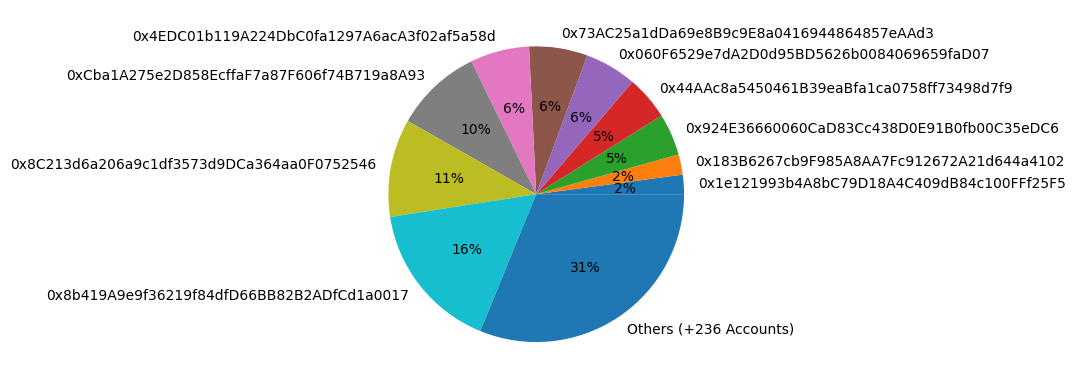

In [7]:
df_draw = df.copy()
df_draw.loc[df_draw['balance'] < 10000000, 'address'] = 'Others (+236 Accounts)'
df_draw = df_draw.groupby('address')['balance'].sum().reset_index()
df_draw = df_draw.sort_values('balance')

plt.pie(df_draw['balance'], labels=df_draw['address'], autopct='%.0f%%');

In [8]:
# print final info for report
import tabulate

df['percent'] = df['balance'] / int(totalSupply) * 10**20
df['airdrop'] = df['balance'] / int(totalSupply) * 10**18 * DISTRO
df.loc[:, "airdrop"] = df["airdrop"].map('{:.18f}'.format)
print(df.to_markdown(tablefmt="github"))

|     | address                                    |   balance |      percent |      airdrop |
|-----|--------------------------------------------|-----------|--------------|--------------|
|   0 | 0x94CE1D981e8D5e4472056949A07C7449e9a36f52 |        80 |  1.61764e-05 |  1.54695e-05 |
|   1 | 0xAD4166C6204025cE9676c7b0c9b9Fe7eb8E946c4 |    451023 |  0.0911989   |  0.0872139   |
|   2 | 0xd552DE9d038eeb158CEc11e70f3Cc108FB0606F2 |    160174 |  0.0323879   |  0.0309727   |
|   3 | 0x29E3DdF94d76C97FcD43D07Fc8B15A03AD233A40 |    385300 |  0.0779094   |  0.0745051   |
|   4 | 0x29ebCD4aCfd3fF9AA028377A8b1330D452694fC1 |      5201 |  0.00105167  |  0.00100571  |
|   5 | 0x343Ab7AaE68b8E57Eb7127B82F0a2239280bB66f |     38027 |  0.00768923  |  0.00735324  |
|   6 | 0x060F6529e7dA2D0d95BD5626b0084069659faD07 |  27585515 |  5.57792     |  5.33418     |
|   7 | 0x36276E35F6A7251013FaEA3E26e01e6B77c1A6b1 |   4313285 |  0.872166    |  0.834056    |
|   8 | 0x512729EB12DfeBBFA67B6D23dC44605bB1DFd5a7

In [9]:
print(df.to_csv(index=False, columns=['address', 'airdrop']))

address,airdrop
0x94CE1D981e8D5e4472056949A07C7449e9a36f52,0.000015469521950264
0xAD4166C6204025cE9676c7b0c9b9Fe7eb8E946c4,0.087213877482171590
0xd552DE9d038eeb158CEc11e70f3Cc108FB0606F2,0.030972690110768971
0x29E3DdF94d76C97FcD43D07Fc8B15A03AD233A40,0.074505085092956932
0x29ebCD4aCfd3fF9AA028377A8b1330D452694fC1,0.001005712295791511
0x343Ab7AaE68b8E57Eb7127B82F0a2239280bB66f,0.007353243890033411
0x060F6529e7dA2D0d95BD5626b0084069659faD07,5.334184122522812821
0x36276E35F6A7251013FaEA3E26e01e6B77c1A6b1,0.834055712315532660
0x512729EB12DfeBBFA67B6D23dC44605bB1DFd5a7,0.002284461654005173
0x56aA4fB42f77fAa81B5cA0d2b3Cab33f80899648,0.000000966845121891
0xE32650e748e7E4aba16181D9882D15ba328d5a78,0.116174949632333158
0x96A6f29ca861B7420c586E070Fbc767E357BA821,0.083237630233880713
0xf29146543824ebAB2524df0be117FC278Dc8d8F6,0.002799983472997707
0x6d04B3f82a0B42A09F355fEA3bCCCE3C819Ad5B5,0.258948775413022636
0x57E7c6692119dE4272bF0f4E173FFD30c8473b5f,0.078328377442964572
0x0DcF4e60dBB7D5d3a68aF5